In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math
from cmcrameri import cm


In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
precursor_definition_method = 'pasef'
experiment_base_dir = '/media/big-ssd/experiments'
experiment_dir = "{}/{}".format(experiment_base_dir, experiment_name)
converted_db_name = "{}/converted-databases/exp-{}-run-{}-converted.sqlite".format(experiment_dir, experiment_name, run_name)

In [3]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [4]:
mz_lower = 700
mz_upper = 720
rt_lower = 1620
rt_upper = 1680

In [5]:
# load the raw points for this worker
db_conn = sqlite3.connect(converted_db_name)
raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == {} and retention_time_secs >= {} and retention_time_secs <= {} and mz >= {} and mz <= {}".format(FRAME_TYPE_MS1, rt_lower, rt_upper, mz_lower, mz_upper), db_conn)
db_conn.close()

In [63]:
RT_BIN_SIZE = 5
SCAN_BIN_SIZE = 20
MZ_BIN_SIZE = 0.1

In [64]:
rt_bins = pd.interval_range(start=raw_points_df.retention_time_secs.min(), end=raw_points_df.retention_time_secs.max()+RT_BIN_SIZE, freq=RT_BIN_SIZE)
scan_bins = pd.interval_range(start=raw_points_df.scan.min(), end=raw_points_df.scan.max()+SCAN_BIN_SIZE, freq=SCAN_BIN_SIZE)
mz_bins = pd.interval_range(start=raw_points_df.mz.min(), end=raw_points_df.mz.max()+MZ_BIN_SIZE, freq=MZ_BIN_SIZE)


In [65]:
raw_points_df['rt_bin'] = pd.cut(raw_points_df.retention_time_secs, bins=rt_bins)
raw_points_df['scan_bin'] = pd.cut(raw_points_df.scan, bins=scan_bins)
raw_points_df['mz_bin'] = pd.cut(raw_points_df.mz, bins=mz_bins)

In [66]:
raw_points_df.sample(n=5)

,frame_id,mz,scan,intensity,retention_time_secs,rt_bin,scan_bin,mz_bin
853040,14727,716.296687,225,51,1662.617101,"(1660.2759204823533, 1665.2759204823533]","(213, 233]","(716.2814231650989, 716.3819256776617]"
682330,14647,701.336720,169,28,1654.148293,"(1650.2759204823533, 1655.2759204823533]","(153, 173]","(701.3065487932396, 701.4070513058024]"
1014701,14807,719.385020,138,41,1671.083844,"(1670.2759204823533, 1675.2759204823533]","(133, 153]","(719.2964985419833, 719.3970010545461]"
414551,14517,706.850547,574,110,1640.389983,"(1640.2759204823533, 1645.2759204823533]","(573, 593]","(706.8341869841944, 706.9346894967572]"
1059847,14827,715.402943,683,11,1673.198998,"(1670.2759204823533, 1675.2759204823533]","(673, 693]","(715.3769005520336, 715.4774030645964]"


In [67]:
summary_df = raw_points_df.groupby(['mz_bin','scan_bin','rt_bin'], as_index=False, sort=False).intensity.sum()

In [68]:
summary_df.dropna(subset = ['intensity'], inplace=True)

In [69]:
summary_df.sort_values(by=['intensity'], ascending=False, inplace=True)

In [70]:
summary_df.head(n=10)

,mz_bin,scan_bin,rt_bin,intensity
98345,"(718.2914734163552, 718.391975928918]","(133, 153]","(1645.2759204823533, 1650.2759204823533]",453748.0
31699,"(705.8291618585662, 705.929664371129]","(653, 673]","(1655.2759204823533, 1660.2759204823533]",453297.0
98357,"(718.2914734163552, 718.391975928918]","(153, 173]","(1645.2759204823533, 1650.2759204823533]",419655.0
18144,"(703.3165990444959, 703.4171015570587]","(573, 593]","(1620.2759204823533, 1625.2759204823533]",326459.0
34399,"(706.3316744213803, 706.4321769339431]","(653, 673]","(1655.2759204823533, 1660.2759204823533]",325519.0
1734,"(700.3015236676114, 700.4020261801743]","(213, 233]","(1650.2759204823533, 1655.2759204823533]",252488.0
20844,"(703.8191116073099, 703.9196141198727]","(573, 593]","(1620.2759204823533, 1625.2759204823533]",236279.0
92926,"(717.286448290727, 717.3869508032898]","(93, 113]","(1670.2759204823533, 1675.2759204823533]",235081.0
85174,"(715.7789106022848, 715.8794131148476]","(673, 693]","(1670.2759204823533, 1675.2759204823533]",228207.0
31687,"(705.8291618585662, 705.929664371129]","(633, 653]","(1655.2759204823533, 1660.2759204823533]",212766.0


In [71]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)

In [72]:
voxel_s = summary_df.iloc[0]
mz_lower = voxel_s.mz_bin.left
mz_upper = voxel_s.mz_bin.right
scan_lower = voxel_s.scan_bin.left
scan_upper = voxel_s.scan_bin.right
rt_lower = voxel_s.rt_bin.mid-0.5
rt_upper = voxel_s.rt_bin.mid+0.5
rt_midpoint = voxel_s.rt_bin.mid

In [73]:
voxel_df = raw_points_df[(raw_points_df.mz >= mz_lower) & (raw_points_df.mz <= mz_upper) & (raw_points_df.scan >= scan_lower) & (raw_points_df.scan <= scan_upper) & (raw_points_df.retention_time_secs >= rt_lower) & (raw_points_df.retention_time_secs <= rt_upper)]


#### anchor point as most intense in the voxel

In [74]:
anchor_point_s = voxel_df.loc[voxel_df.intensity.idxmax()]

In [75]:
anchor_point_s

frame_id                                                  14587
mz                                                      718.372
scan                                                        140
intensity                                                  7020
retention_time_secs                                      1647.8
rt_bin                 (1645.2759204823533, 1650.2759204823533]
scan_bin                                             (133, 153]
mz_bin                    (718.2914734163552, 718.391975928918]
Name: 551750, dtype: object

In [76]:
ANCHOR_POINT_MZ_LOWER_OFFSET = 0.6   # one isotope for charge-2 plus a little bit more
ANCHOR_POINT_MZ_UPPER_OFFSET = 3.0   # six isotopes for charge-2 plus a little bit more

ANCHOR_POINT_SCAN_LOWER_OFFSET = 100
ANCHOR_POINT_SCAN_UPPER_OFFSET = 100

In [77]:
mz_lower = anchor_point_s.mz - ANCHOR_POINT_MZ_LOWER_OFFSET
mz_upper = anchor_point_s.mz + ANCHOR_POINT_MZ_UPPER_OFFSET
scan_lower = anchor_point_s.scan - ANCHOR_POINT_SCAN_LOWER_OFFSET
scan_upper = anchor_point_s.scan + ANCHOR_POINT_SCAN_UPPER_OFFSET

In [78]:
anchor_frame_df = raw_points_df[(raw_points_df.frame_id == anchor_point_s.frame_id) & (raw_points_df.mz >= mz_lower) & (raw_points_df.mz <= mz_upper) & (raw_points_df.scan >= scan_lower) & (raw_points_df.scan <= scan_upper)]


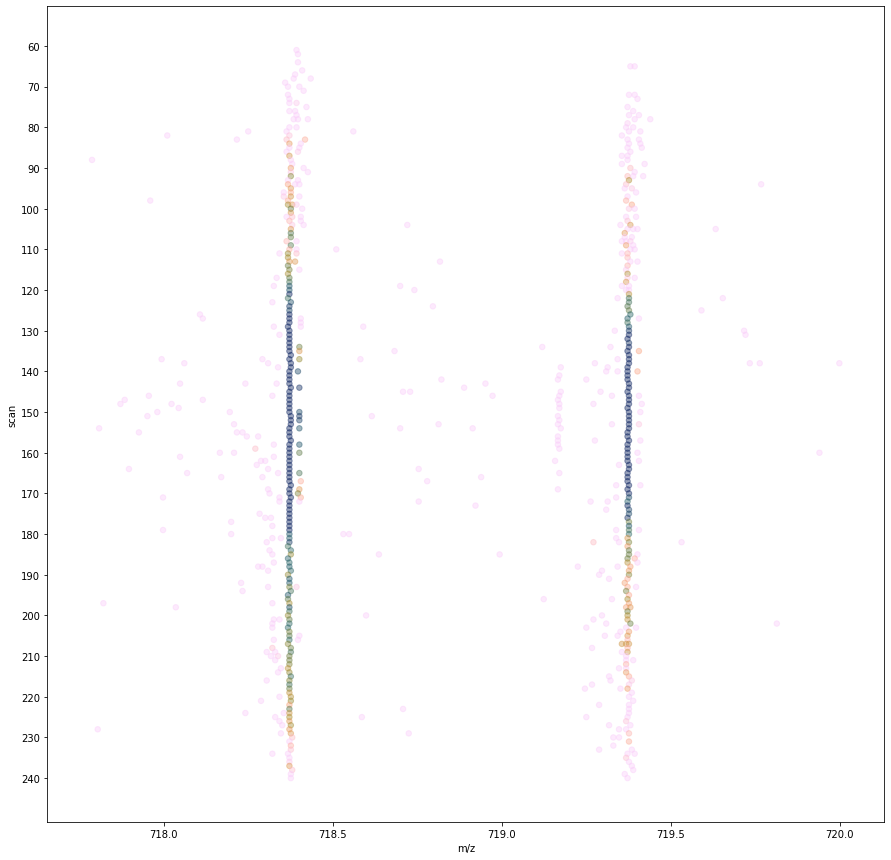

In [79]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(anchor_frame_df.mz, anchor_frame_df.scan, c=anchor_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(anchor_frame_df.mz.min() / nearest) * nearest
range_u = round(anchor_frame_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(anchor_frame_df.scan.min() / nearest) * nearest
range_u = round(anchor_frame_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.gca().invert_yaxis()
plt.show()

#### anchor point as the voxel midpoint

In [80]:
def frame_id_for_rt(voxel_df, rt):
    df = voxel_df.copy()
    df['rt_delta'] = abs(voxel_df.retention_time_secs - rt)
    df.sort_values(by=['rt_delta'], ascending=True, inplace=True)
    return df.iloc[0].frame_id

In [81]:
frame_id_for_rt(voxel_df, rt_midpoint)

14587